# Evolution

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 11

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

In [2]:
class FitnessLandscape:
    def __init__(self, N):
        """Create a landscape.
        
        
        """
        self.N = N
        self.cache = dict()

    def random_loc(self):
        """Choose a random location."""
        # in NumPy version 1.11 we can pass dtype to randint
        #return randint(self.A, size=self.N).astype(np.int8)
        return np.random.randint(2, size=self.N, dtype=np.int8)
    
    def fitness(self, loc):
        """Evaluates the fitness of a location.
        
        loc: array of N 0s and 1s
        
        returns: float fitness
        """
        key = tuple(loc)
        return self.cache.setdefault(key, np.random.random())

In [12]:
land = FitnessLandscape(5)
land

In [13]:
loc = land.random_loc()
loc, land.fitness(loc)

(array([0, 1, 1, 1, 1], dtype=int8), 0.615)

In [14]:
land.cache

{(0, 1, 1, 1, 1): 0.615}

In [15]:
loc, land.fitness(loc)

(array([0, 1, 1, 1, 1], dtype=int8), 0.615)

In [16]:
loc = land.random_loc()
loc, land.fitness(loc)

(array([0, 1, 0, 0, 1], dtype=int8), 0.669)

## The agents



In [17]:
class Agent:
    """Represents an agent in an NK model."""
    
    def __init__(self, loc, landscape):
        """Create an agent at the given location.
        
        loc: array of N 0s and 1s
        landscape: reference to an landscape
        """
        self.loc = loc
        self.landscape = landscape
        self.fitness = landscape.fitness(self.loc)
        
    def copy(self):
        return Agent(self.loc, self.landscape)

In [18]:
loc = land.random_loc()
agent = Agent(loc, land)
agent.loc, agent.fitness

(array([1, 0, 1, 1, 1], dtype=int8), 0.975)

## The simulator



In [20]:
class Simulation:
    
    def __init__(self, landscape, num_agents, agent_maker):
        """Create the simulation:
        
        landscape: landscape
        num_agents: int number of agents
        agent_maker: function that makes agents
        """
        self.landscape = landscape
        locs = [land.random_loc() for _ in range(num_agents)]
        agents = [agent_maker(loc, landscape) for loc in locs]
        self.agents = np.array(agents)
        self.instruments = []
        
    def add_instrument(self, instrument):
        """
        """
        self.instruments.append(instrument)
        
    def step(self):
        """Run step on each agent.
        
        returns: list of boolean, whether each agent moves
        """
        n = len(self.agents)
        fits = np.array(self.get_fitnesses())
        
        # see who dies
        index_dead = self.choose_dead(fits)
        num_dead = len(index_dead)
        
        # replace the dead with copies of the living
        replacements = self.choose_replacements(num_dead, fits)
        self.agents[index_dead] = replacements

        # update any instruments
        for instrument in self.instruments:
            instrument.update(self)
        
    def get_locs(self):
        """Returns a list of agent locations."""
        return [tuple(agent.loc) for agent in self.agents]
    
    def get_fitnesses(self):
        """Returns a list of agent fitnesses."""
        return [agent.fitness for agent in self.agents]
    
    def choose_dead(self, fits):
        n = len(self.agents)
        is_dead = np.random.random(n) > fits
        index_dead = np.nonzero(is_dead)[0]
        return index_dead
        
    def choose_replacements(self, n, fits):
        p = fits / np.sum(fits)
        agents = np.random.choice(self.agents, size=n, replace=True, p=p)
        replacements = [agent.copy() for agent in agents]
        return replacements

In [21]:
land = FitnessLandscape(5)
sim = Simulation(land, 100, Agent)

In [22]:
def plot_fitnesses(sim):
    fits = sim.get_fitnesses()
    cdf_fitness = Cdf(fits)
    thinkplot.Cdf(cdf_fitness)
    return np.mean(fits)

0.488

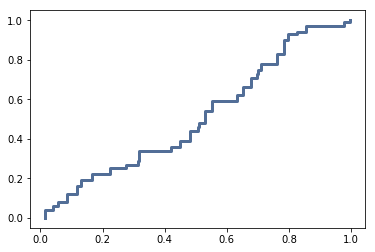

In [23]:
plot_fitnesses(sim)

0.647

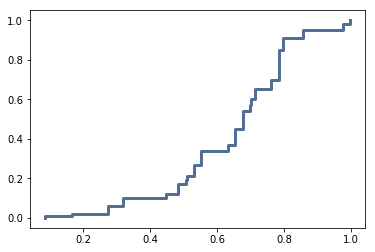

In [24]:
sim.step()
plot_fitnesses(sim)

In [28]:
class MeanFitnessInstrument:
    
    def __init__(self):
        self.means = []
        
    def update(self, sim):
        mean = np.mean(sim.get_fitnesses())
        self.means.append(mean)

In [32]:
def run_simulation(instrument_makers, N=5, num_agents=50, num_steps=50):
    land = FitnessLandscape(N)
    sim = Simulation(land, num_agents, Agent)
    
    for instrument_maker in instrument_makers:
        instrument = instrument_maker()
        sim.add_instrument(instrument)

    for i in range(num_steps):
        sim.step()
        
    return sim

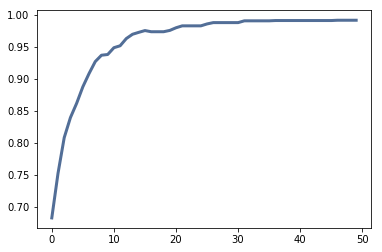

In [34]:
instrument_makers = [MeanFitnessInstrument]
sim = run_simulation(instrument_makers)
instrument = sim.instruments[0]
thinkplot.plot(instrument.means)

In [39]:
class UniqueAgentInstrument:
    
    def __init__(self):
        self.uniq_agents = []
        
    def update(self, sim):
        uniq_agents = len(set(sim.get_locs()))
        self.uniq_agents.append(uniq_agents)


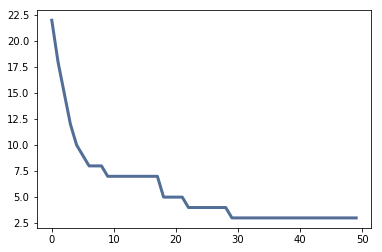

In [41]:
instrument_makers = [UniqueAgentInstrument]
sim = run_simulation(instrument_makers)
instrument = sim.instruments[0]
thinkplot.plot(instrument.uniq_agents)

In [ ]:
class Mutant(Agent):
    
    prob_mutate = 0.05
    
    def copy(self):
        if np.random.random() > self.prob_mutate:
            loc = self.loc.copy()
        else:
            direction = np.random.randint(self.landscape.N)
            loc = self.mutate(direction)
        return Mutant(loc, self.landscape)
    
    def mutate(self, direction):
        """Computes the location in the given direction.
        
        Result differs from the current location along the given axis.
        
        direction: int index from 0 to N-1
        
        returns: new array of N 0s and 1s
        """
        new_loc = self.loc.copy()
        new_loc[direction] ^= 1
        return new_loc

In [ ]:
loc = land.random_loc()
agent = Mutant(loc, land)
agent.loc

In [ ]:
for i in range(20):
    copy = agent.copy()
    print(agent.loc == copy.loc)

In [ ]:
land = FitnessLandscape(5)
sim = Simulation2(land, 100, Mutant)

for i in range(50):
    sim.step()

In [ ]:
thinkplot.plot(sim.uniq_agents)

Here's how the distribution of fitness evolves after each step.

In [ ]:
thinkplot.PrePlot(7)

sim = Simulation(land, 100, AgentFitter)

for i in range(7):
    cdf_fitness = Cdf(sim.get_fitnesses())
    thinkplot.Cdf(cdf_fitness)
    sim.step()

After every agent has found a peak, we can plot the distribution of fitness.

In [ ]:
cdf_fitness = Cdf(sim.get_fitnesses())
thinkplot.Cdf(cdf_fitness)

The number of unique locations is a lower bound on the number of peaks.

In [ ]:
peaks = sim.get_peaks()
len(peaks)

And we can look at the heights of the peaks.

In [ ]:
heights = sim.get_peak_heights()
heights

Here's the distribution of path lengths.  A few agents are born on a peak.  The longest path is probably 5 or fewer.

In [ ]:
cdf_moves = Cdf(sim.get_path_lengths())
thinkplot.Cdf(cdf_moves)

This function encapsulates the steps for running a simulation:

In [ ]:
def run_simulation(N=5, K=2, num_agents=100, agent_maker=AgentFitter):
    """Create a simulation and run until all agents find a peak.
    
    N: int number of traits
    K: int number of interactions
    num_agents: int number of agents
    agent_maker: function that creates agents
    
    returns Simulation object
    """
    land = landscape(N, K)
    sim = Simulation(land, num_agents, agent_maker)
    for i in range(100):
        steps = sim.step()
        if np.sum(steps) == 0:
            break
    return sim

Here's the same small example:

In [ ]:
sim = run_simulation(N=5, K=2)

This function takes a completed simulation and summarizes the results.

In [ ]:
def plot_results(sim):
    """Summarizes simulation results.
    
    sim: Simulation object
    """
    cdf_fitness = Cdf(sim.get_fitnesses())
    peaks = sim.get_peaks()
    heights = sim.get_peak_heights()
    cdf_moves = Cdf(sim.get_path_lengths())
    
    print("Mean fitness: ", cdf_fitness.Mean())
    print("Mean path length: ", cdf_moves.Mean())
    print("Number of peaks:", len(peaks))

    thinkplot.PrePlot(cols=2)
    thinkplot.Cdf(cdf_fitness)
    thinkplot.Config(xlabel='Fitness', ylabel='CDF')

    thinkplot.SubPlot(2)
    thinkplot.Cdf(cdf_moves)
    thinkplot.Config(xlabel='Path Length', ylabel='CDF')

And here are the result with small values of `N` and `K`.

In [ ]:
plot_results(sim)

Here's a simulation run with larger `N` and `K`:

In [ ]:
%time sim = run_simulation(N=40, K=20)
plot_results(sim)

**Exercise:** Starting with `N=5` and `K=3`, run simulations with increasing values of `N`, keeping `K` constant, and plot the number of peaks and mean path length as a function of `N`.

In [ ]:
# Solution

K = 3
res = []

ns = range(5, 30)
for N in ns:
    sim = run_simulation(N, K)
    num_peaks = len(sim.get_peaks())
    mean_path = np.mean(sim.get_path_lengths())
    res.append((num_peaks, mean_path))
    
peaks, paths = np.transpose(res)

In [ ]:
# Solution

thinkplot.Plot(ns, peaks)
thinkplot.Config(xlabel='N', ylabel='Number of peaks')

In [ ]:
# Solution

thinkplot.Plot(ns, paths)
thinkplot.Config(xlabel='N', ylabel='Mean path length')

**Exercise:** Starting with `N=20` and `K=0`, run simulations with increasing values of `K`, keeping `N` constant, and plot the number of peaks and mean path length as a function of `K`.

In [ ]:
# Solution

N = 20
res = []

ks = range(0, 20)
for K in ks:
    sim = run_simulation(N, K)
    num_peaks = len(sim.get_peaks())
    mean_path = np.mean(sim.get_path_lengths())
    res.append((num_peaks, mean_path))
    
peaks, paths = np.transpose(res)

In [ ]:
# Solution

thinkplot.Plot(ks, peaks)
thinkplot.Config(xlabel='N', ylabel='Number of peaks')

In [ ]:
# Solution

thinkplot.Plot(ks, paths)
thinkplot.Config(xlabel='N', ylabel='Mean path length')